In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from matplotlib import pyplot as PLT
#from google.colab import drive                IF you are using COLAB

In [2]:
def extract_data(x_data_filepath, y_data_filepath):
    X = np.load(x_data_filepath)
    y = np.load(y_data_filepath)
    return X, y

In [3]:
def data_visualization(images,labels):
    
    for i in range(5):
        index = np.where(labels==i)
        X_v = images[index]
        for r in range(7):
            im_show = X_v[r]
            im_show = im_show.reshape((64,85,3))
            PLT.imshow(im_show)
            PLT.show

    
    """
    Visualize 6 pictures per class using your prefered visulization library (matplotlib, etc)

    Args:
        images: training images in shape (num_images,3,image_H,image_W)
        labels: training labels in shape (num_images,)
    """

In [4]:
############################################################
# Extracting and loading data
############################################################
class Dataset(Dataset):
    def __init__(self, X, y):
        self.len = len(X)           
        if torch.cuda.is_available():
            self.x_data = torch.from_numpy(X).float().cuda()
            self.y_data = torch.from_numpy(y).long().cuda()
        else:
            self.x_data = torch.from_numpy(X).float()
            self.y_data = torch.from_numpy(y).long()
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [5]:
def create_validation(x_train,y_train):
    
#     new_x_train = x_train[0:2081]
#     new_y_train = y_train[0:2081]
    
#     x_val = x_train[2081:2601]
#     y_val = y_train[2081:2601]

    data_length = len(x_train)
    
    train_range = range(0,round(0.8*data_length))
    valid_range = range(round(0.8*data_length),data_length)
    get_data = Dataset(x_train,y_train)
    
    new_x_train,new_y_train = get_data.__getitem__(train_range) 
                                                   
    x_val,y_val = get_data.__getitem__(valid_range) 
    
    """
    Randomly choose 20 percent of the training data as validation data.

    Args:
        x_train: training images in shape (num_images,3,image_H,image_W)
        y_train: training labels in shape (num_images,)
    Returns:
        new_x_train: training images in shape (0.8*num_images,3,image_H,image_W)
        new_y_train: training labels in shape (0.8*num_images,)
        x_val: validation images in shape (0.2*num_images,3,image_H,image_W)
        y_val: validation labels in shape (0.2*num_images,)
    """
    return new_x_train,new_y_train,x_val,y_val

In [6]:
############################################################
# Feed Forward Neural Network
############################################################
class FeedForwardNN(nn.Module):
    """ 
        (1) Use self.fc1 as the variable name for your first fully connected layer
        (2) Use self.fc2 as the variable name for your second fully connected layer
    """
    def __init__(self):
        
        super().__init__()
        self.fc1 = nn.Linear(16320,2000);
        self.fc2 = nn.Linear(2000,5)

    def forward(self, x):
        
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = F.relu(x)
        out = self.fc2(x)

        return out

    """ 
        Please do not change the functions below. 
        They will be used to test the correctness of your implementation 
    """
    def get_fc1_params(self):
        return self.fc1.__repr__()
    
    def get_fc2_params(self):
        return self.fc2.__repr__()

In [39]:
############################################################
# Convolutional Neural Network
############################################################
class ConvolutionalNN(nn.Module):
    """ 
        (1) Use self.conv1 as the variable name for your first convolutional layer
        (2) Use self.pool1 as the variable name for your first pooling layer
        (3) Use self.conv2 as the variable name for your second convolutional layer
        (4) Use self.pool2 as the variable name for you second pooling layer  
        (5) Use self.fc1 as the variable name for your first fully connected laye
        (6) Use self.fc2 as the variable name for your second fully connected layer
    """
    def __init__(self):
        super(ConvolutionalNN,self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size = 3, stride = 1, padding = 0)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(16,32,kernel_size = 3, stride = 1, padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(32*14*19,200)
        self.fc2 = nn.Linear(200,5)
        
      
    def forward(self, x):
#         x_numpy = x.cpu().numpy()
#         x = normalize_image(x_numpy)
#         x = torch.from_numpy(x).cuda()
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        out = x.reshape(x.size(0),-1)
        out = self.dropout(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        
        return out
      
    """ 
        Please do not change the functions below. 
        They will be used to test the correctness of your implementation
    """
    
    def get_conv1_params(self):
        return self.conv1.__repr__()
    
    def get_pool1_params(self):
        return self.pool1.__repr__()

    def get_conv2_params(self):
        return self.conv2.__repr__()
      
    def get_pool2_params(self):
        return self.pool2.__repr__()
      
    def get_fc1_params(self):
        return self.fc1.__repr__()
    
    def get_fc2_params(self):
        return self.fc2.__repr__()

In [8]:
def normalize_image(image):
    
    mean_R = np.mean(image[0,:,:])
    mean_G = np.mean(image[1,:,:])
    mean_B = np.mean(image[2,:,:])
    
    std_R = np.std(image[0,:,:])
    std_G = np.std(image[1,:,:])
    std_B = np.std(image[2,:,:])
    
    norimg = image.copy()
    
    norimg[0,:,:] = (image[0,:,:] - mean_R)/std_R
    norimg[1,:,:] = (image[1,:,:] - mean_G)/std_G
    norimg[2,:,:] = (image[2,:,:] - mean_B)/std_B
    
    return norimg
    
    
    """
    Normalize each input image

    Args:
        image: the input image in shape (3,image_H,image_W)
    Returns:
        norimg: the normalized image in the same shape as the input
    """

In [9]:
############################################################
# Optimized Neural Network
############################################################
class OptimizedNN(nn.Module):
    def __init__(self):
        super(OptimizedNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3,stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3,stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3,stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(3072, 200)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(200, 5)
        self.dropout2 = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x_numpy = x.cpu().numpy()
        x = normalize_image(x_numpy)
        x = torch.from_numpy(x).cuda()
        out = F.relu(self.conv1(x))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out)
        out = F.relu(self.conv3(out))
        out = self.pool3(out)
        out = out.view(out.size(0),-1)
        out = self.dropout1(out)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.fc2(out)
        return out
      

In [44]:
def train_val_NN(neural_network, train_loader, validation_loader, loss_function, optimizer,num_epochs):
    
    total_step = len(train_loader)
    loss_list = []
    accuracy = []
    val_accuracy = []
    
    print("Starting the training")
    
    for epoch in range(40):
#         print("Starting with the first Epoch")
        for i, (images, labels) in enumerate(train_loader):
            outputs = neural_network(images)
            loss = criterion(outputs, labels)
            

            # Backprop and perform optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()      

            # Track the accuracy
            total_train = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct_train = (predicted == labels).sum().item()
            
            
            #check the validation set
            neural_network.eval()
            with torch.no_grad():
                correct = 0
                total = 0
                for images, labels in validation_loader:
                    outputs = neural_network(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_val = labels.size(0)
                    correct_val = (predicted == labels).sum().item()
        #update lists for the accuracies and losses
        print('For training: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct_train / total_train) * 100))
        loss_list.append(loss.item())
        val_accuracy.append(correct_val / total_val)
        accuracy.append(correct_train / total_train)
#         print('for validation: Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
#                    .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
#                            (correct_val / total_val) * 100))
    """
    Runs experiment on the model neural network given a train loader, loss function and optimizer and find validation accuracy for each epoch given the validation_loader.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        train_loader (DataLoader),
        validation_loader (DataLoader),
        loss_function (torch.nn.CrossEntropyLoss),
        optimizer (optim.SGD)
        num_epochs (number of iterations)
    Returns:
        tuple: First position, training accuracies of each epoch formatted in an array of shape (num_epochs,1).
               Second position, training loss of each epoch formatted in an array of shape (num_epochs,1).
               third position, validation accuracy of each epoch formatted in an array of shape (num_epochs,1).
               
    """

  
    return accuracy,loss_list,val_accuracy

In [11]:
def test_NN(neural_network, test_loader, loss_function):
  
    """
    Runs experiment on the model neural network given a test loader, loss function and optimizer.

    Args:
        neural_network (NN model that extends torch.nn.Module): For example, it should take an instance of either
                                                                FeedForwardNN or ConvolutionalNN,
        test_loader (DataLoader), (make sure the loader is not shuffled)
        loss_function (torch.nn.CrossEntropyLoss),
        optimizer (your choice)
        num_epochs (number of iterations)
    Returns:
        your predictions         
    """
    neural_network.eval()
    Preds = []
    with torch.no_grad():
        for images in test_loader:
            check = images[0]
            outputs = neural_network(check)
            _, predicted = torch.max(outputs.data, 1)
            Preds.append(predicted)
  
    return Preds

In [12]:
X,y = extract_data('data/images_train.npy', 'data/labels_train.npy')

new_x_train,new_y_train,x_val,y_val = create_validation(X,y)

print(new_x_train.shape)


if torch.cuda.is_available():
    X_total = torch.from_numpy(X).float().cuda()
    y_total = torch.from_numpy(y).long().cuda()
else:
    X_total = torch.from_numpy(X).float()
    y_total = torch.from_numpy(y).long()

train_data_set = TensorDataset(new_x_train,new_y_train)
total_data_set = TensorDataset(X_total,y_total)
valid_data_set = TensorDataset(x_val,y_val)


total_loader = DataLoader(dataset = total_data_set, batch_size = 64, shuffle = True)
train_loader = DataLoader(dataset = train_data_set, batch_size = 64, shuffle = True)
valid_loader = DataLoader(dataset = valid_data_set, batch_size = 64, shuffle = True)



torch.Size([2081, 3, 64, 85])


In [32]:
# Run Baseline FeedForward
    
NN_model = FeedForwardNN()
NN_model.cuda()
criterion = nn.CrossEntropyLoss()
criterion.cuda()
optimizer = torch.optim.Adagrad(NN_model.parameters(),lr = 0.001)
# optimizer.cuda()
epochs = 40
accuracy_list,loss_list,val_list = train_val_NN(NN_model,train_loader, valid_loader, criterion,optimizer,epochs)
print(len(accuracy_list))

Starting the training
for validation: Epoch [1/40], Step [33/33], Loss: 2.0150, Accuracy: 25.00%
for validation: Epoch [2/40], Step [33/33], Loss: 1.4697, Accuracy: 50.00%
for validation: Epoch [3/40], Step [33/33], Loss: 1.4249, Accuracy: 25.00%
for validation: Epoch [4/40], Step [33/33], Loss: 1.2817, Accuracy: 37.50%


KeyboardInterrupt: 

Text(0.5, 1.0, 'accuracy curve over epochs with blue for training and orange for testing \n with normalized images')

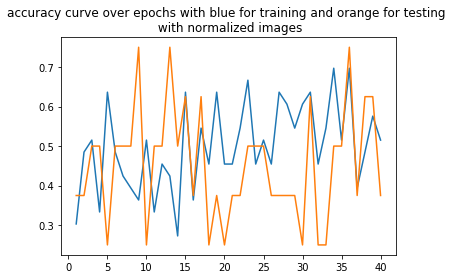

In [31]:
epoch_list = range(1,41)
PLT.plot(epoch_list,accuracy_list)
# PLT.plot(epoch_list,loss_list)
PLT.plot(epoch_list,val_list)
PLT.title("accuracy curve over epochs with blue for training and orange for testing \n with normalized images")
# PLT.title("loss curve over epochs or testing data with normalized images", /n "with normalized images")

In [42]:
# Run Baseline CNN
CNN_model = ConvolutionalNN()
CNN_model.cuda()
criterion = nn.CrossEntropyLoss()
criterion.cuda()
optimizer = torch.optim.Adagrad(CNN_model.parameters(),lr = 0.001)
epochs = 40
accuracy_list,loss_list,val_list = train_val_NN(CNN_model,train_loader, valid_loader, criterion,optimizer,epochs)



Starting the training
for validation: Epoch [1/40], Step [33/33], Loss: 1.3101, Accuracy: 25.00%
for validation: Epoch [2/40], Step [33/33], Loss: 1.2265, Accuracy: 37.50%
for validation: Epoch [3/40], Step [33/33], Loss: 1.3295, Accuracy: 25.00%
for validation: Epoch [4/40], Step [33/33], Loss: 1.3489, Accuracy: 75.00%
for validation: Epoch [5/40], Step [33/33], Loss: 1.1648, Accuracy: 62.50%
for validation: Epoch [6/40], Step [33/33], Loss: 1.2147, Accuracy: 62.50%
for validation: Epoch [7/40], Step [33/33], Loss: 1.0807, Accuracy: 37.50%
for validation: Epoch [8/40], Step [33/33], Loss: 0.8705, Accuracy: 62.50%
for validation: Epoch [9/40], Step [33/33], Loss: 1.0932, Accuracy: 87.50%
for validation: Epoch [10/40], Step [33/33], Loss: 1.2924, Accuracy: 62.50%
for validation: Epoch [11/40], Step [33/33], Loss: 0.9899, Accuracy: 62.50%
for validation: Epoch [12/40], Step [33/33], Loss: 1.0122, Accuracy: 62.50%
for validation: Epoch [13/40], Step [33/33], Loss: 1.1015, Accuracy: 50.00%

Text(0.5, 1.0, 'accuracy curve over epochs with blue for training and orange for testing \n for normalized images')

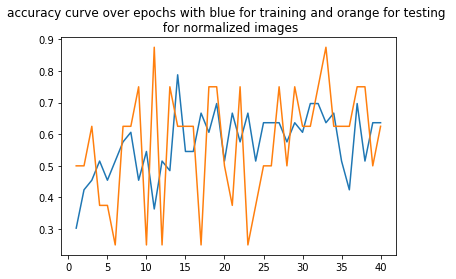

In [36]:
epoch_list = range(1,41)
PLT.plot(epoch_list,accuracy_list)
# PLT.plot(epoch_list,loss_list)
PLT.plot(epoch_list,val_list)
# PLT.title("loss curve over epochs for training for normalized images")
PLT.title("accuracy curve over epochs with blue for training and orange for testing \n for normalized images")

In [45]:
# Run optimized CNN on Normilized Images

OCNN_model = OptimizedNN()
OCNN_model.cuda()
criterion = nn.CrossEntropyLoss()
criterion.cuda()
optimizer = torch.optim.Adam(OCNN_model.parameters(),lr = 0.001)
epochs = 40
accuracy_list,loss_list,val_list = train_val_NN(OCNN_model,train_loader, valid_loader, criterion,optimizer,epochs)


Starting the training
For training: Epoch [1/40], Step [33/33], Loss: 1.5372, Accuracy: 33.33%
For training: Epoch [2/40], Step [33/33], Loss: 1.3670, Accuracy: 42.42%
For training: Epoch [3/40], Step [33/33], Loss: 1.3106, Accuracy: 54.55%
For training: Epoch [4/40], Step [33/33], Loss: 1.3922, Accuracy: 42.42%
For training: Epoch [5/40], Step [33/33], Loss: 1.2256, Accuracy: 48.48%
For training: Epoch [6/40], Step [33/33], Loss: 1.1245, Accuracy: 60.61%
For training: Epoch [7/40], Step [33/33], Loss: 0.9333, Accuracy: 66.67%
For training: Epoch [8/40], Step [33/33], Loss: 1.2894, Accuracy: 39.39%
For training: Epoch [9/40], Step [33/33], Loss: 0.8620, Accuracy: 72.73%
For training: Epoch [10/40], Step [33/33], Loss: 1.0142, Accuracy: 54.55%
For training: Epoch [11/40], Step [33/33], Loss: 0.5873, Accuracy: 75.76%
For training: Epoch [12/40], Step [33/33], Loss: 0.9012, Accuracy: 60.61%
For training: Epoch [13/40], Step [33/33], Loss: 0.5900, Accuracy: 78.79%
For training: Epoch [14/4

Text(0.5, 1.0, 'accuracy curve over epochs with blue for training and orange for testing')

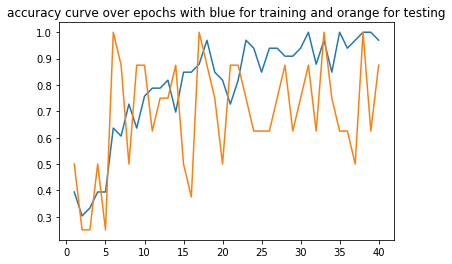

In [21]:
epoch_list = range(1,41)
PLT.plot(epoch_list,accuracy_list)
# PLT.plot(epoch_list,loss_list)
PLT.plot(epoch_list,val_list)
# PLT.title("loss curve over epochs for training")
PLT.title("accuracy curve over epochs with blue for training and orange for testing")

In [ ]:
OCNNT_model = OptimizedNN()
OCNNT_model.cuda()
criterion = nn.CrossEntropyLoss()
criterion.cuda()
optimizer = torch.optim.Adam(OCNNT_model.parameters(),lr = 0.001)
epochs = 40
accuracy_list,loss_list,val_list = train_val_NN(OCNNT_model,total_loader, valid_loader, criterion,optimizer,epochs)
test_data = np.load('data/images_test.npy')
test_data = torch.from_numpy(test_data).float().cuda()
# torch.tensor(test_data, dtype = torch.float32)
test_dataset = torch.utils.data.TensorDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=32)
predicted = test_NN(OCNNT_model, test_loader, criterion)

In [ ]:
import numpy as np
# print(list(predicted[0].shape)[0])
with open('HW4_preds.txt', 'w', encoding = 'utf8') as file:
    for i in range(len(predicted)):
        tensor = predicted[i]
        for n in range(list(predicted[i].shape)[0]):
            file.write(str(predicted[i][n].item())+'\n')